In [24]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from lalframe.utils import frtools

### Getting Omicron triggers

(3885842,)


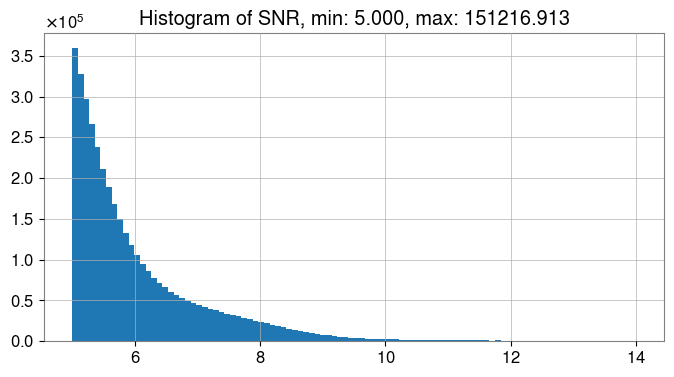

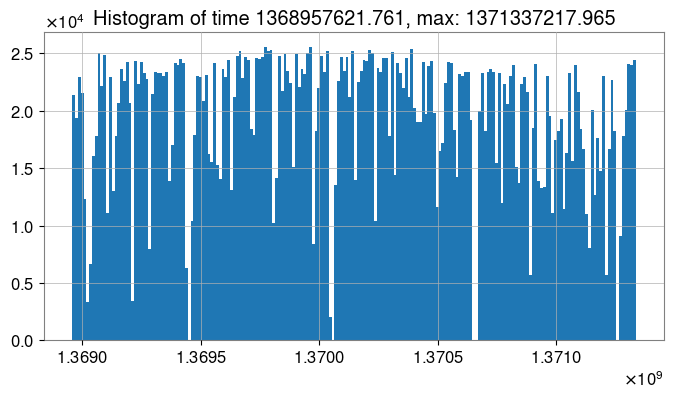

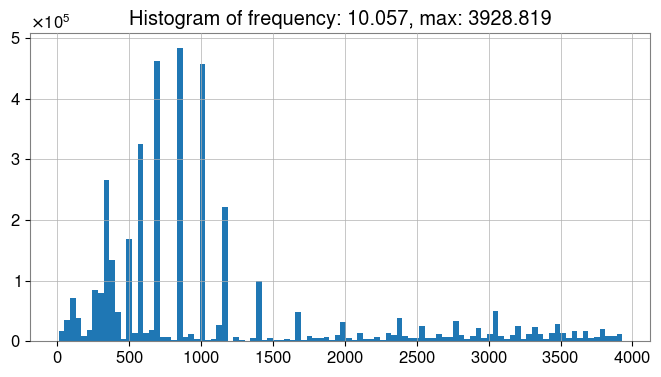

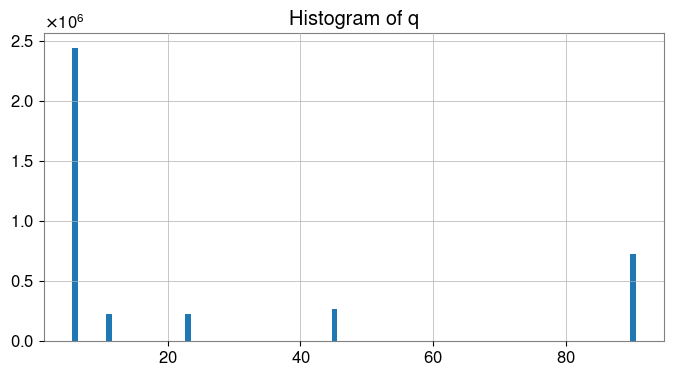

In [26]:
trigger_file = "./K1-HPF_4.hdf5"
with h5py.File(trigger_file, 'r') as f:
    triggers = f['triggers'][:]

print(triggers.shape)
snr = triggers['snr']
time = triggers['time']
frequency = triggers['frequency']
q = triggers['q']
plt.figure(figsize=[8,4])
plt.title(f"Histogram of SNR, min: {snr.min():.3f}, max: {snr.max():.3f}")
plt.hist(snr, bins=100, range=(5,14))
plt.show()

plt.figure(figsize=[8,4])
plt.title(f"Histogram of time {time.min():.3f}, max: {time.max():.3f}")
plt.hist(time, bins=200)
plt.show()

plt.figure(figsize=[8,4])
plt.title(f"Histogram of frequency: {frequency.min():.3f}, max: {frequency.max():.3f}")
plt.hist(frequency, bins=100)
plt.show()

plt.figure(figsize=[8,4])
plt.title(f"Histogram of q")
plt.hist(q, bins=100)
plt.show()

### Q-transform

In [88]:
# Find the segments of a given GPS
def find_segment(
    seg_file: str,
    time: float,
):
    with open(seg_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            start = float(line.strip().split(' ')[0])
            end = float(line.strip().split(' ')[1])
            if (time >= start) and (time <= end):
                seg = (start, end)
                break
            else:
                seg = None
                continue
            
        if seg is not None:
            return seg
        else:
            print(f"Cannot find the segment that {time} belongs to in {seg_file}.")

# Define a function to get the asd for whitening
def calculate_asd(
        source: list,
        channel: str,
        start: float,
        end: float,
        fftlength: float=32,
        overlap: float=16,
):
    ts = TimeSeries.read(
        source=source,
        channel=channel,
        start=start,
        end=end,
    )
    asd = ts.asd(
        fftlength=fftlength,
        overlap=overlap,
        method='median',
    )
    return asd

# Define a function to get all of the spectrogram
def calculate_spectrogram(
        source: list,
        channel: str,
        trigger_info,
        asd,
        window_length: float=2,
        crop_length: float=1,
        offset: float=0,
        qrange: tuple=(50,50),
        frange: tuple=(5, 1500),
        tres: float=1/200,
        fres: float=0.5,
):
    trigger_time = trigger_info['time']
    start = trigger_time - (window_length/2 + crop_length) + offset
    end = trigger_time + (window_length/2 + crop_length) + offset
    ts = TimeSeries.read(
        source=source,
        channel=channel,
        start=start,
        end=end,
    )
    wh_ts = ts.whiten(asd=asd)
    ts_bd = wh_ts.bandpass(frange[0], frange[1])
    qspec = ts_bd.q_transform(
        qrange=qrange,
        frange=frange,
        tres=tres,
        logf=True,
        fres=fres,
        whiten=False,
    )
    qspec_crop = qspec.crop(start+crop_length, end-crop_length)
    return ts, qspec_crop

### Filtering triggers by SNR

In [124]:
filter_id = []
for i, trigger in enumerate(triggers):
    if trigger['snr'] >= 50 and trigger['snr'] <= 10000:
        filter_id.append(i)

filtered_triggers = triggers[filter_id]
print(filtered_triggers.shape)
print(filtered_triggers.dtype)

(634,)
[('time', '<f8'), ('frequency', '<f8'), ('tstart', '<f8'), ('tend', '<f8'), ('fstart', '<f8'), ('fend', '<f8'), ('snr', '<f8'), ('q', '<f8'), ('amplitude', '<f8'), ('phase', '<f8')]


In [133]:
# target_time = 1371289493.320312
target_time = 1371291192.916381
for i, time in enumerate(filtered_triggers['time']):
    if time == target_time:
        print(i)

619


In [185]:
# Test 
channel = "K1:CAL-CS_PROC_DARM_STRAIN_DBL_DQ"
seg_file = "./K1-GRD_SCIENCE_MODE_NO_IPC_ERROR_SEGMENT_UTC_O4a.txt"
data_dir = "/data/KAGRA/raw/science"
id = 613
trigger = filtered_triggers[id]
print(trigger['time'])
seg = find_segment(seg_file, trigger['time'])

f_labels = [int(seg[0]/1e5), int(seg[1]/1e5)]
if f_labels[1] > f_labels[0]:
    source = []
    for f_label in f_labels:
        gwfs = glob.glob(f"{data_dir}/{f_label}/*.gwf")
        source.extend(gwfs)

else:
    source = glob.glob(f"{data_dir}/{f_labels[0]}/*.gwf")

duration = 10
st = trigger['time'] - duration/2
ed = trigger['time'] + duration/2
fftlength = 8
overlap = fftlength/2
flow, fhigh = 30, 4000
qlow, qhigh = 50, 50
tres = 1/100
fres = 100
crop_length = 9/2

asd_st = st - 64
asd_ed = st
asd_ts = TimeSeries.read(
    source=source,
    channel=channel,
    start=asd_st,
    end=asd_ed,
)
asd = asd_ts.asd(
    fftlength=fftlength,
    overlap=overlap,
    method='median',
)
# seg = find_segment(
#     seg_file=seg_file,
#     time=trigger['time'],
# )
# asd_st, asd_ed = seg
# asd = calculate_asd(
#     source=source,
#     channel=channel,
#     start=asd_st,
#     end=asd_ed,
#     fftlength=fftlength,
#     overlap=overlap,
# )

ts = TimeSeries.read(
    source=source,
    channel=channel,
    start=st,
    end=ed,
)
wh_ts = ts.whiten(asd=asd)
bd_ts = wh_ts.bandpass(flow, fhigh)

qspec = bd_ts.q_transform(
    qrange=(qlow, qhigh),
    frange=(flow, fhigh),
    tres=tres,
    fres=fres,
    logf=True,
    whiten=False,
)
crop_st = ts.t0.value + crop_length
crop_ed = ts.t0.value + ts.duration.value - crop_length
qspec_crop = qspec.crop(crop_st, crop_ed)

output_file = "/home/chia-jui.chou/glitch-data/K1-O4a/K1_qspecs_snrge50_test.hdf5"
chosen_triggers = np.stack([trigger])
qspec_data = np.stack([qspec_crop.value])
xindex = np.stack([qspec_crop.xindex.value])
yindex = np.stack([qspec_crop.yindex.value])
with h5py.File(output_file, 'w') as f:
    f.create_dataset(
        "triggers",
        shape=chosen_triggers.shape,
        dtype=chosen_triggers.dtype,
        data=chosen_triggers,
    )
    f.create_dataset(
        "qspec",
        shape=qspec_data.shape,
        dtype=qspec_data.dtype,
        data=qspec_data,
    )
    f.create_dataset(
        "xindex",
        shape=xindex.shape,
        dtype=xindex.dtype,
        data=xindex,
    )
    f.create_dataset(
        "yindex",
        shape=yindex.shape,
        dtype=yindex.dtype,
        data=yindex,
    )

1371241569.351867


(100, 100)


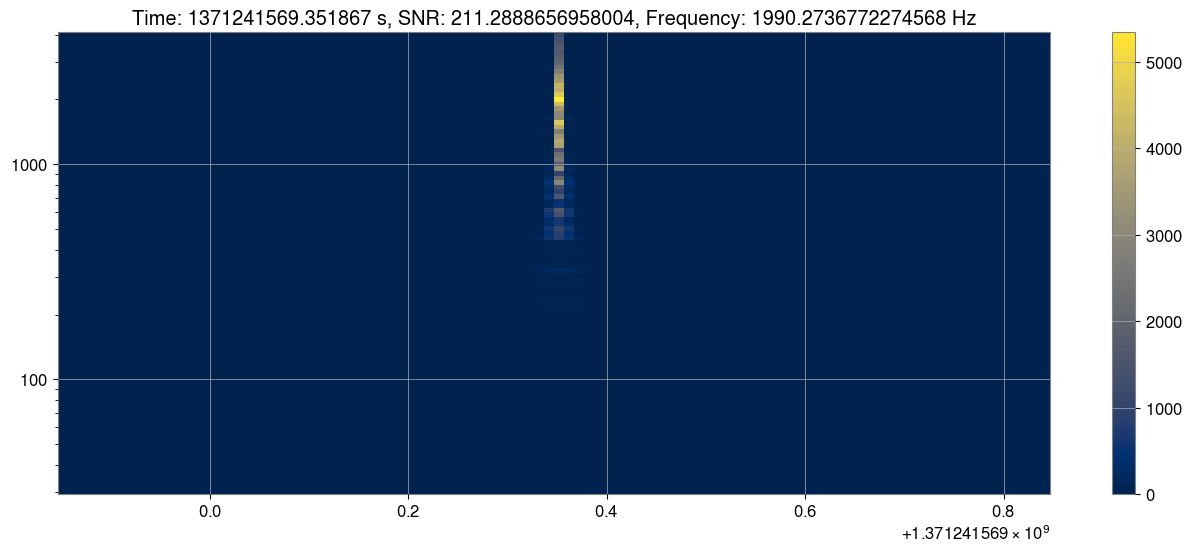

In [186]:
with h5py.File(output_file, 'r') as f:
    trigger = f['triggers'][0]
    qspec = f['qspec'][0]
    xindex = f['xindex'][0]
    yindex = f['yindex'][0]

print(qspec.shape)
plt.figure(figsize=[16,6])
plt.title(f"Time: {trigger['time']} s, SNR: {trigger['snr']}, Frequency: {trigger['frequency']} Hz")
plt.pcolormesh(
    xindex,
    yindex,
    qspec.T,
    cmap='cividis',
    # vmin=100,
    # vmax=20,
)
plt.colorbar(cmap='cividis')
plt.yscale('log')
plt.show()

In [167]:
print(trigger.dtype)
print(trigger)
print(trigger['tstart'])

[('time', '<f8'), ('frequency', '<f8'), ('tstart', '<f8'), ('tend', '<f8'), ('fstart', '<f8'), ('fend', '<f8'), ('snr', '<f8'), ('q', '<f8'), ('amplitude', '<f8'), ('phase', '<f8')]
(1.37128375e+09, 49.38707875, 1.37128375e+09, 1.37128378e+09, 18.77220267, 3862.39657468, 51.37382777, 90.50966799, 1.30147461e-19, -2.98865596)
1371283752.125


2


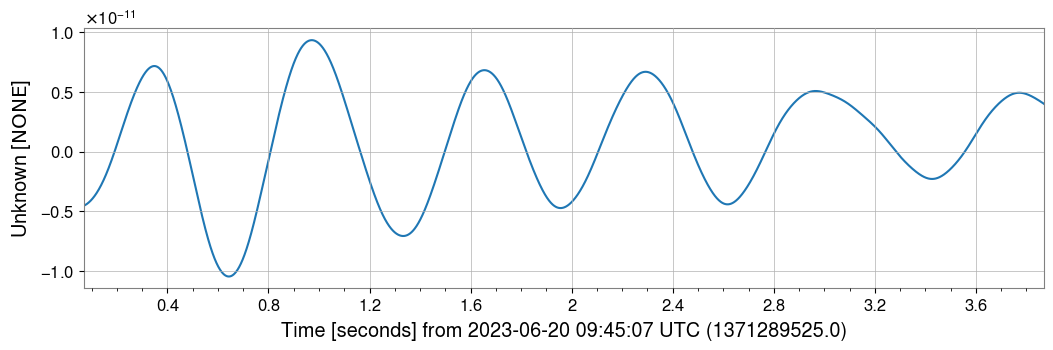

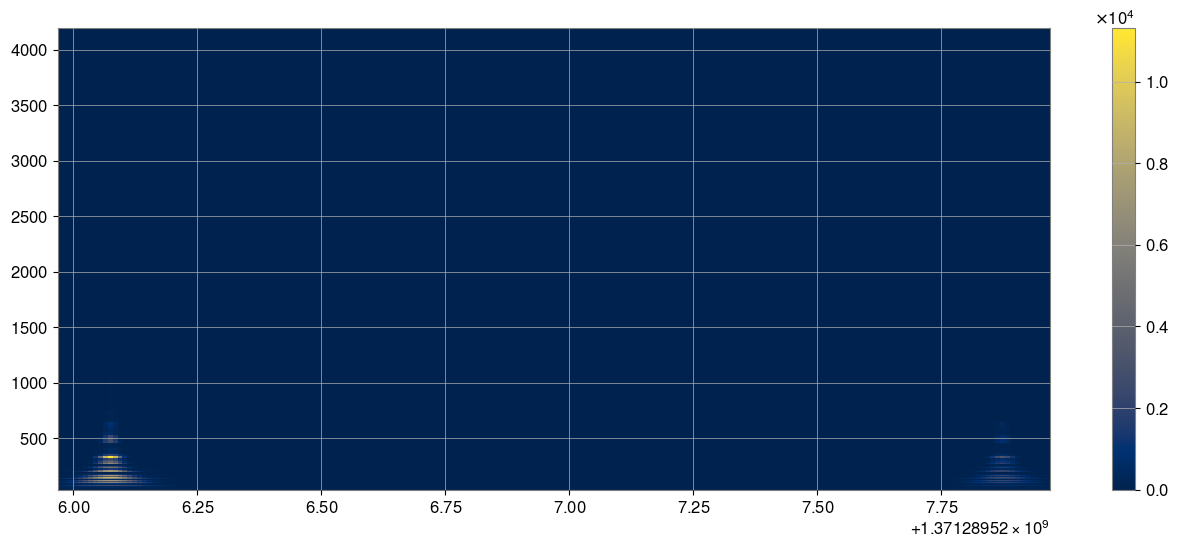

In [67]:
channel = "K1:CAL-CS_PROC_DARM_STRAIN_DBL_DQ"
seg_file = "./K1-GRD_SCIENCE_MODE_NO_IPC_ERROR_SEGMENT_UTC_O4a.txt"
data_dir = "/data/KAGRA/raw/science"

# id_start, id_end = 900, 1000
# for id_start in range(1000, 2000, 100):
# id_end = id_start + 100
id_start, id_end = 45027, 45028
output_dir = "/home/chia-jui.chou/glitch-data/K1-O4a"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
output_file = f"{output_dir}/K1_qspecs_snrge10le50_{id_start}-{id_end}.hdf5"

# Setting window lengths and the size of the spectrograms
window_lengths = [0.25, 0.5, 1, 2]
pixel_length = 400
tress = [window_length/pixel_length for window_length in window_lengths]
window_length_max = np.max(window_lengths)

# Processing data
merged_specs = []
for i in range(id_start, id_end):
    # Get the segment and the source of the time series
    trigger = filtered_triggers[i]
    seg = find_segment(seg_file, trigger['time'])
    # seg = (1368957619, 1368957619+1615)

    f_labels = [int(seg[0]/1e5), int(seg[1]/1e5)]
    if f_labels[1] > f_labels[0]:
        source = []
        for f_label in f_labels:
            gwfs = glob.glob(f"{data_dir}/{f_label}/*.gwf")
            source.extend(gwfs)

    else:
        source = glob.glob(f"{data_dir}/{f_labels[0]}/*.gwf")

    # ASD of the segment
    asd = calculate_asd(
        source=source,
        channel=channel,
        start=seg[0],
        end=seg[1],
    )

    # Calculate q-spectrograms
    output_qspecs = []
    for tres, window_length in zip(tress[-1:], window_lengths[-1:]):
        print(window_length)
        # Setting parameters for Q-transform
        crop_length = 0.9
        offset = 0.0*window_length
        qrange = (50, 50)
        frange = (30, 4000)
        tres = 1/100
        fres = 100
        # Q-transform
        ts, qspec = calculate_spectrogram(
            source=source,
            channel=channel,
            trigger_info=trigger,
            asd=asd,
            window_length=window_length,
            crop_length=crop_length,
            offset=offset,
            qrange=qrange,
            frange=frange,
            tres=tres,
            fres=fres,
        )

        ts.plot()
        plt.figure(figsize=[16,6])
        plt.pcolormesh(
            qspec,
            cmap='cividis',
        )
        plt.colorbar(cmap='cividis')
        plt.show()
        output_qspecs.append(qspec)

#     # Merge 4 spectrograms
#     qspec_row_n = output_qspecs[0].T.value.shape[0]
#     qspec_column_n = output_qspecs[0].T.value.shape[1]
#     data_shape = (2*qspec_column_n, 2*qspec_row_n)
#     merged_spec = np.zeros(shape=data_shape)
#     merged_spec[:qspec_column_n, :qspec_row_n] = output_qspecs[0].value
#     merged_spec[:qspec_column_n, qspec_row_n:] = output_qspecs[1].value
#     merged_spec[qspec_column_n:, :qspec_row_n] = output_qspecs[2].value
#     merged_spec[qspec_column_n:, qspec_row_n:] = output_qspecs[3].value

#     # Append the merged spectrogram to a list merged_specs
#     merged_specs.append(merged_spec)

# # Save merged_specs to a hdf5 file
# with h5py.File(output_file, 'w') as f:
#     trigger_data = filtered_triggers[id_start:id_end]
#     f.create_dataset(
#         "triggers",
#         shape=trigger_data.shape,
#         dtype=trigger_data.dtype,
#         data=trigger_data,
#     )

#     qspec_data = np.stack(merged_specs)
#     f.create_dataset(
#         "qspecs",
#         shape=qspec_data.shape,
#         dtype=qspec_data.dtype,
#         data=qspec_data,
#     )
#     f['qspecs'].attrs['channel'] = channel
#     f['qspecs'].attrs['window_lengths'] = window_lengths
#     f['qspecs'].attrs['crop_length'] = crop_length
#     f['qspecs'].attrs['qrange'] = np.array(qrange)
#     f['qspecs'].attrs['frange'] = np.array(frange)
#     f['qspecs'].attrs['tres'] = np.array(tress)
#     f['qspecs'].attrs['fres'] = fres

In [71]:
print(ts.t0.value)
print(ts.duration.value)
print(ts)

1371289525.0687256
3.79998779296875
TimeSeries([-4.52204035e-12, -4.52146901e-12, -4.52088272e-12,
            ...,  4.02350433e-12,  4.02259363e-12,
             4.02168625e-12]
           unit: NONE,
           t0: 1371289525.0687256 s,
           dt: 6.103515625e-05 s,
           name: K1:CAL-CS_PROC_DARM_STRAIN_DBL_DQ,
           channel: K1:CAL-CS_PROC_DARM_STRAIN_DBL_DQ)


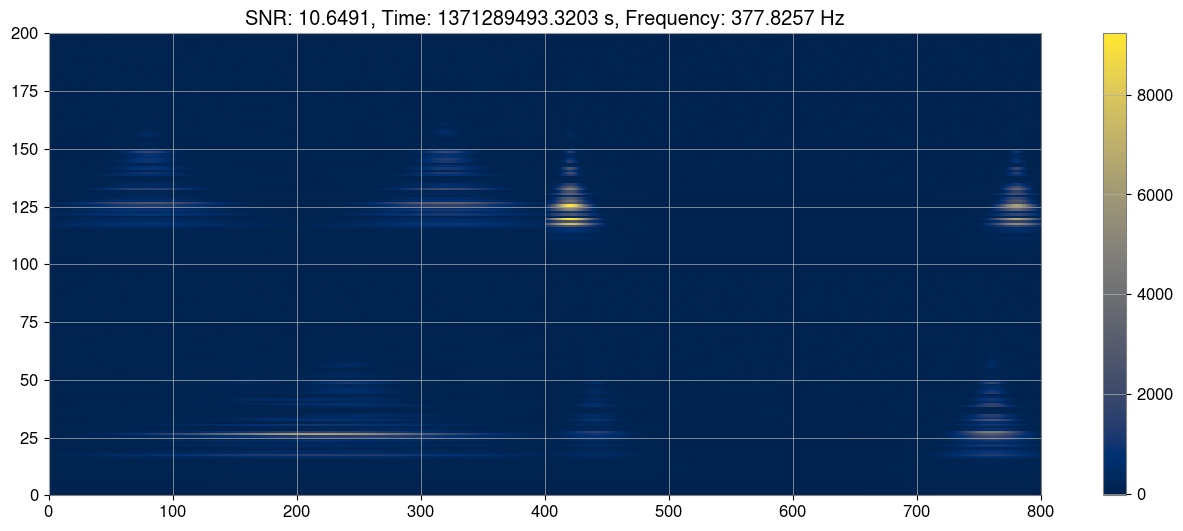

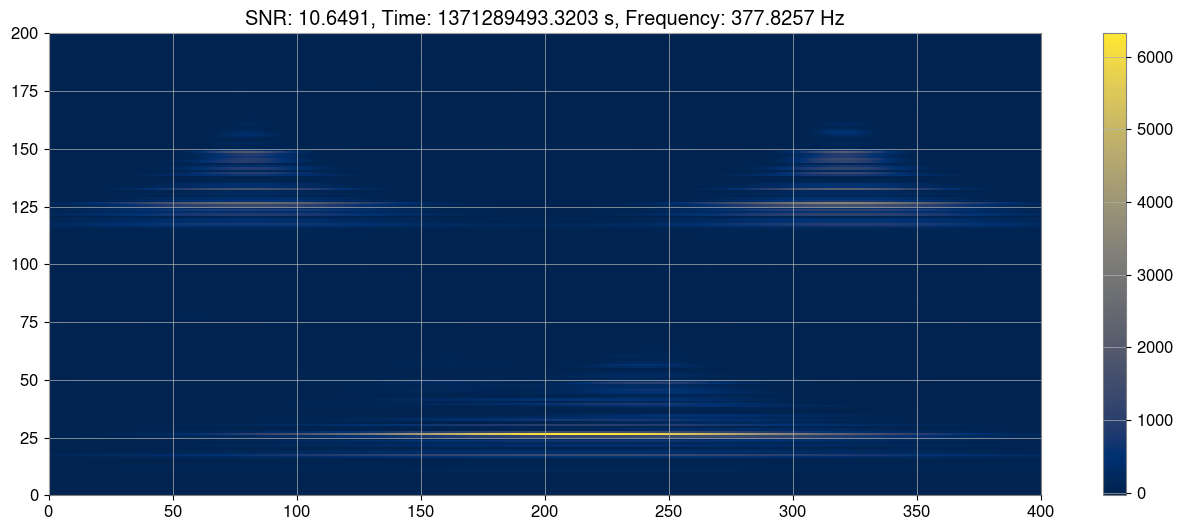

In [56]:
id_start, id_end = 45026, 45027
output_dir = "/home/chia-jui.chou/glitch-data/K1-O4a"
output_file = f"{output_dir}/K1_qspecs_snrge10le50_{id_start}-{id_end}.hdf5"
spec_id = 0
with h5py.File(output_file, 'r') as f:
    chosen_spec = f['qspecs'][spec_id]
    trigger = f['triggers'][spec_id]

plt.figure(figsize=[16,6])
plt.title(f"SNR: {trigger['snr']:.4f}, Time: {trigger['time']:.4f} s, Frequency: {trigger['frequency']:.4f} Hz")
plt.pcolormesh(
    chosen_spec.T,
    cmap='cividis',
)
plt.colorbar(cmap='cividis')
plt.show()

n_coloumn = 800
n_row = 598
spec_0 = chosen_spec[:int(n_coloumn/2), :int(n_row/2)]
spec_1 = chosen_spec[:int(n_coloumn/2), int(n_row/2):int(n_row)]
spec_2 = chosen_spec[int(n_coloumn/2):int(n_coloumn), :int(n_row/2)]
spec_3 = chosen_spec[int(n_coloumn/2):int(n_coloumn), int(n_row/2):int(n_row)]

plt.figure(figsize=[16,6])
plt.title(f"SNR: {trigger['snr']:.4f}, Time: {trigger['time']:.4f} s, Frequency: {trigger['frequency']:.4f} Hz")
plt.pcolormesh(
    spec_0.T,
    cmap='cividis',
)
plt.colorbar(cmap='cividis')
plt.show()

# plt.figure(figsize=[16,6])
# plt.title(f"SNR: {trigger['snr']:.4f}, Time: {trigger['time']:.4f} s, Frequency: {trigger['frequency']:.4f} Hz")
# plt.pcolormesh(
#     spec_1.T,
#     cmap='cividis',
# )
# plt.colorbar(cmap='cividis')
# plt.show()

# plt.figure(figsize=[16,6])
# plt.title(f"SNR: {trigger['snr']:.4f}, Time: {trigger['time']:.4f} s, Frequency: {trigger['frequency']:.4f} Hz")
# plt.pcolormesh(
#     spec_2.T,
#     cmap='cividis',
# )
# plt.colorbar(cmap='cividis')
# plt.show()

# plt.figure(figsize=[16,6])
# plt.title(f"SNR: {trigger['snr']:.4f}, Time: {trigger['time']:.4f} s, Frequency: {trigger['frequency']:.4f} Hz")
# plt.pcolormesh(
#     spec_3.T,
#     cmap='cividis',
# )
# plt.colorbar(cmap='cividis')
# plt.show()